In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
library(edgeR)
library(limma)
# library(MAST)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [8]:
def index(data, name='Unnamed: 0'):
    data.index = pd.Index(data[name])
    data.drop([name], axis=1, inplace=True)
    return data

# ape = index(pd.read_csv('./Ape.csv'))
human = index(pd.read_csv(config.PATHS.CSV/'Human.csv'))

In [7]:
ranks = index(pd.read_csv('./de_edgeR_C5.csv'))

In [8]:
ranked_ape = index(pd.read_csv('./ApeRanked.csv'), 'names')
ranked_ape.drop(['Unnamed: 0'], axis=1, inplace=True)
ranked_human = index(pd.read_csv('./HumanRanked.csv'), 'names')
ranked_human.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
ape = ape.loc[human.index.intersection(ape.index)]
selected = human.loc[human.index.difference(ape.index)]
selected.sort_values('PValue')

,logFC,logCPM,F,PValue,FDR
Unnamed: 0,,,,,
THRA1/BTR,3.098271,3.005200,334.730500,1.001520e-33,2.707588e-31
XIST,1.129779,4.835102,327.642433,9.371086e-33,2.198846e-30
FAM159B,-1.637590,4.115199,276.061101,1.467210e-31,2.991185e-29
NPAS4,-2.669364,3.080659,115.390624,1.433627e-18,7.751561e-17
DRGX,-2.302345,2.463388,114.412268,1.812874e-18,9.634574e-17
...,...,...,...,...,...
MTERF,0.000000,2.520923,0.000000,1.000000e+00,1.000000e+00
MTERFD1,0.000000,1.869898,0.000000,1.000000e+00,1.000000e+00
MYOM2,0.000000,2.594613,0.000000,1.000000e+00,1.000000e+00


In [10]:
selected = ranks

# GO

In [11]:
from pathlib import Path
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [12]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [13]:
import decoupler

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [14]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]

reactome

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,genesymbol,collection,geneset
200,MAFF,reactome_pathways,REACTOME_HEMOSTASIS
342,MAFF,reactome_pathways,REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEV...
718,IER3,reactome_pathways,REACTOME_INTRACELLULAR_SIGNALING_BY_SECOND_MES...
859,IER3,reactome_pathways,REACTOME_NEGATIVE_REGULATION_OF_THE_PI3K_AKT_N...
1104,PHLDA1,reactome_pathways,REACTOME_MITOTIC_G2_G2_M_PHASES
...,...,...,...
3838483,KIR2DS2,reactome_pathways,REACTOME_DAP12_INTERACTIONS
3838489,KIR2DS2,reactome_pathways,REACTOME_INNATE_IMMUNE_SYSTEM
3838499,KIR2DS2,reactome_pathways,REACTOME_ADAPTIVE_IMMUNE_SYSTEM
3838530,KIR3DS1,reactome_pathways,REACTOME_DAP12_INTERACTIONS


In [299]:
ranked_ape = ranked_ape.loc[ranked_human.index.intersection(ranked_ape.index)]
ranked_selected = ranked_human.loc[ranked_human.index.difference(ranked_ape.index)]

idxs = ranked_ape.index
# ranked_human.loc[idxs].pvals_adj /= ranked_ape.loc[idxs].pvals_adj * 10
ranked_selected = pd.concat([ranked_selected, ranked_human.loc[idxs]])

idxs = [ idx for idx in ranked_selected.index if idx.lower()[:3] == 'mt-' ]
ranked_selected.drop(idxs, axis=0, inplace=True)
ranked_selected

,scores,pvals,pvals_adj,logfoldchanges
names,,,,
7SK.1,-3.718076,2.013725e-04,3.796922e-04,-21.754030
A1BG-AS1,-1.157325,2.471955e-01,2.983903e-01,-0.174889
A1CF,-2.644213,8.195422e-03,1.310530e-02,-20.828844
A2M-AS1,0.424816,6.709904e-01,7.371151e-01,0.131169
A2ML1,-5.638556,1.741304e-08,4.224243e-08,-22.847536
...,...,...,...,...
TPM2,-89.519740,0.000000e+00,0.000000e+00,-6.146952
IFITM2,-92.067310,0.000000e+00,0.000000e+00,-6.429821
APOE,-93.439514,0.000000e+00,0.000000e+00,-6.664756


In [300]:
t_stats = ranked_selected[['scores']]
#ranked_selected[
    # (ranked_selected.logfoldchanges.abs() > 1)
    # & (ranked_selected.pvals_adj < 0.1)][['scores']]

In [301]:
t_stats.sort_values('scores')

,scores
names,
IFITM3,-102.948940
BST2,-98.074550
S100A11,-96.733500
APOE,-93.439514
IFITM2,-92.067310
...,...
TMSB10,91.218390
RTN1,98.789910
GAP43,127.228750


In [58]:
print(' '.join(ranks[
    (ranks['FDR'] < .01)# & (np.abs(ranks['logFC']) > 1.5)
].gene_symbol.values))

OSBPL8 EIF4G2 LINC00152 PLA2G16 ANO5 FABP5 ZMIZ2 PLK2 RAB3B PHLDA2 PDLIM1 SHROOM2 ZC3HAV1 RCAN2 SNX10 SUMF2 POU3F2 PLEKHD1 UBA1 TENM4 AK4 KRT18 AC004540.4 METRN MAN2A1 PRRT2 ARL4C FBXO2 ZBED4 PIEZO2 PRKAG2-AS1 SFXN3 MARCH11 PRR4 STX1B CHD5 CACNG7 FAM174A SNCA PPIG CLASP1 CADM3 PBX3 ASCC3 OSTC APEH UTS2B MT-ND3 CHGA UBASH3B C12orf75 PTCHD2 SCN9A MSI1 TMEM158 ENOX1 SRI KLF3 SHD POLR2K S100A10 MIDN TMEM18 FSCN1 NTRK2 MTMR9 USP22 SCRT1 IREB2 HSP90AB1 MXI1 TJP1 DDAH1 HLA-B RP11-710C12.1 TATDN1 ARVCF POR ACTL6B CSNK1E BSN ADD3 RTN4RL2 SDC3 OLFM2 ZNF358 POLE4 ARHGAP22 PELI2 CCT7 ARPC1B TMSB15A SQLE TFRC RNF7 SAP18 ANXA2 TBCK LACTB PHACTR2 ZMAT3 POMT1 TMEM97 CACHD1 CDH2 SAMD11 LMO3 CD36 ARL16 CMC2 SEPT3 PPP2R1A C19orf60 SCN7A FAXC CIT NTNG2 GNAQ ME1 PARVB CPNE3 ZNF609 UBE2QL1 HSPE1 RAB27B RNPS1 YIF1A CORO2A OPTN ATAT1 MAP6 STT3B YIPF3 PARG OTUB1 FAM216A UBE2E3 EBF3 CXXC5 HDDC2 NUDT4 POMP PMEPA1 ABHD12 PBX1 BDP1 UQCRC1


In [23]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [24]:
scores, norm, pvals = decoupler.run_gsea(
    # t_stats.T
    selected[['FDR']].T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


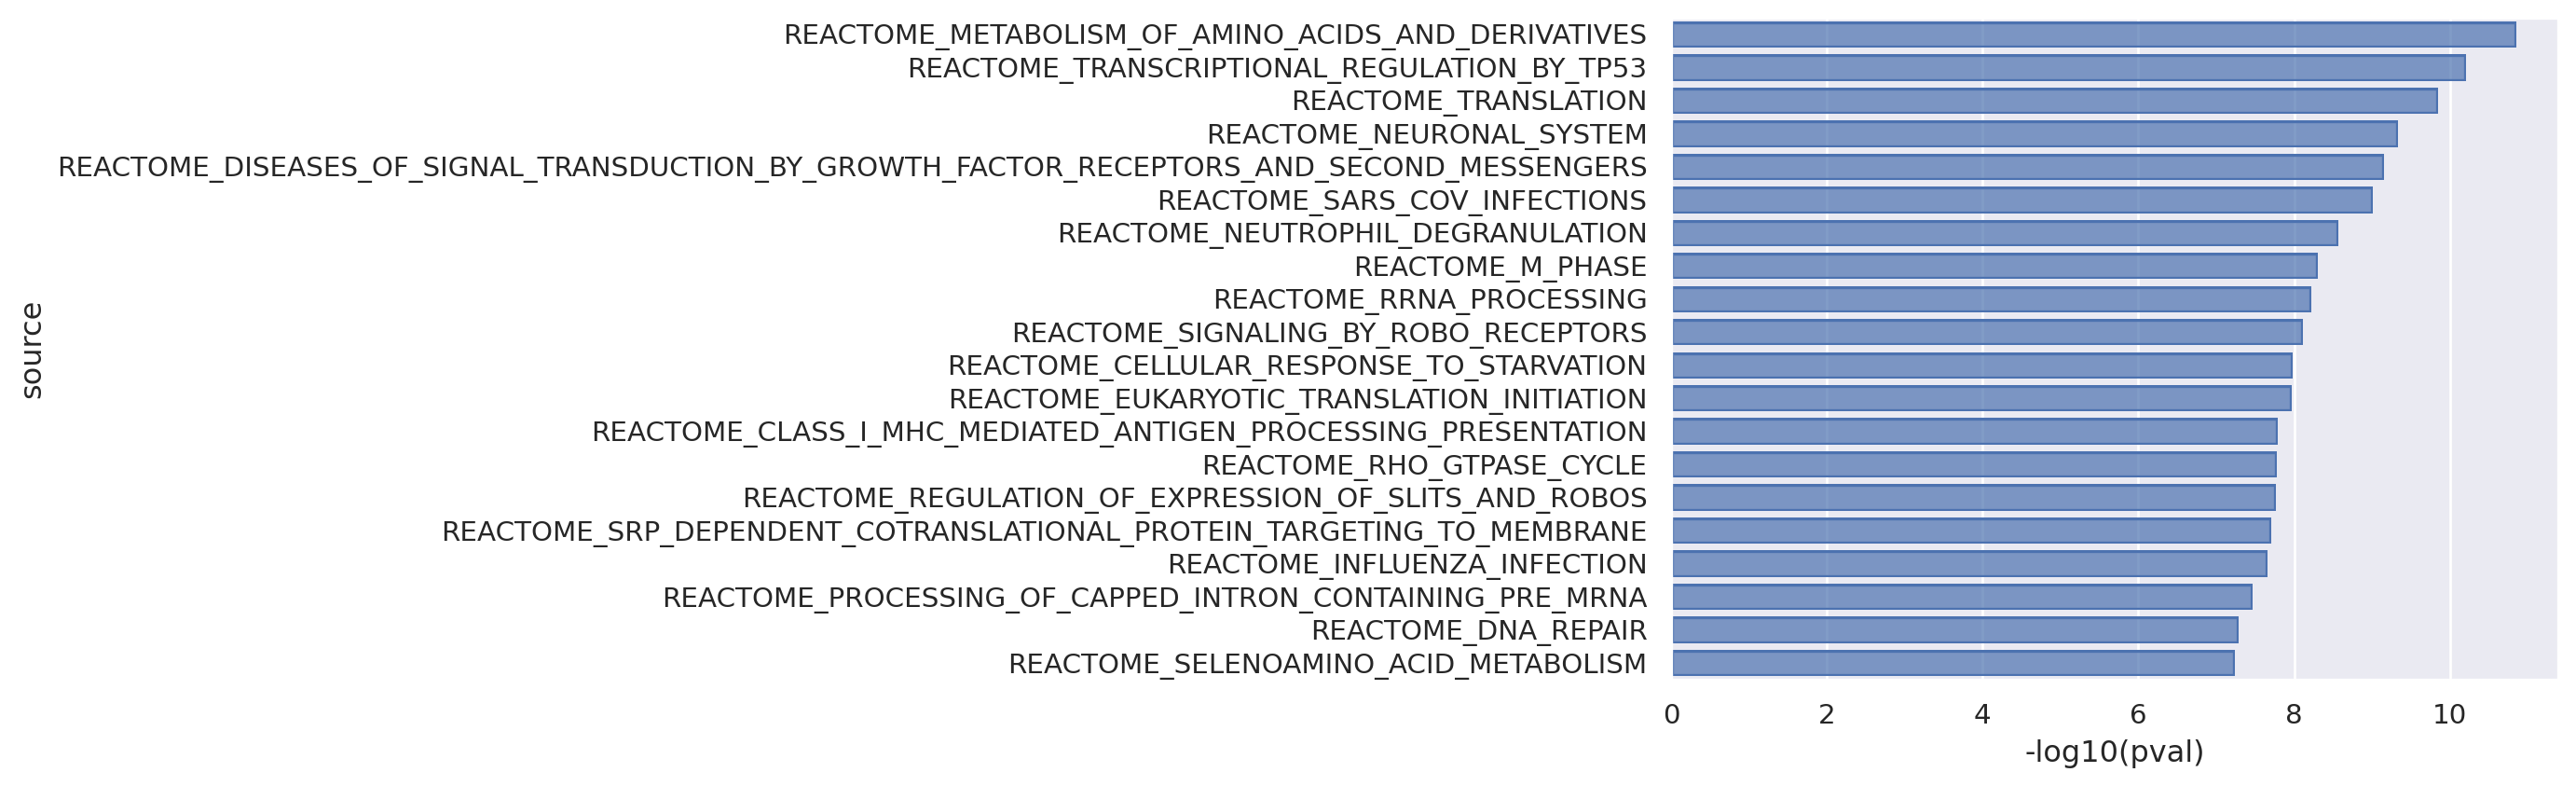

In [25]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


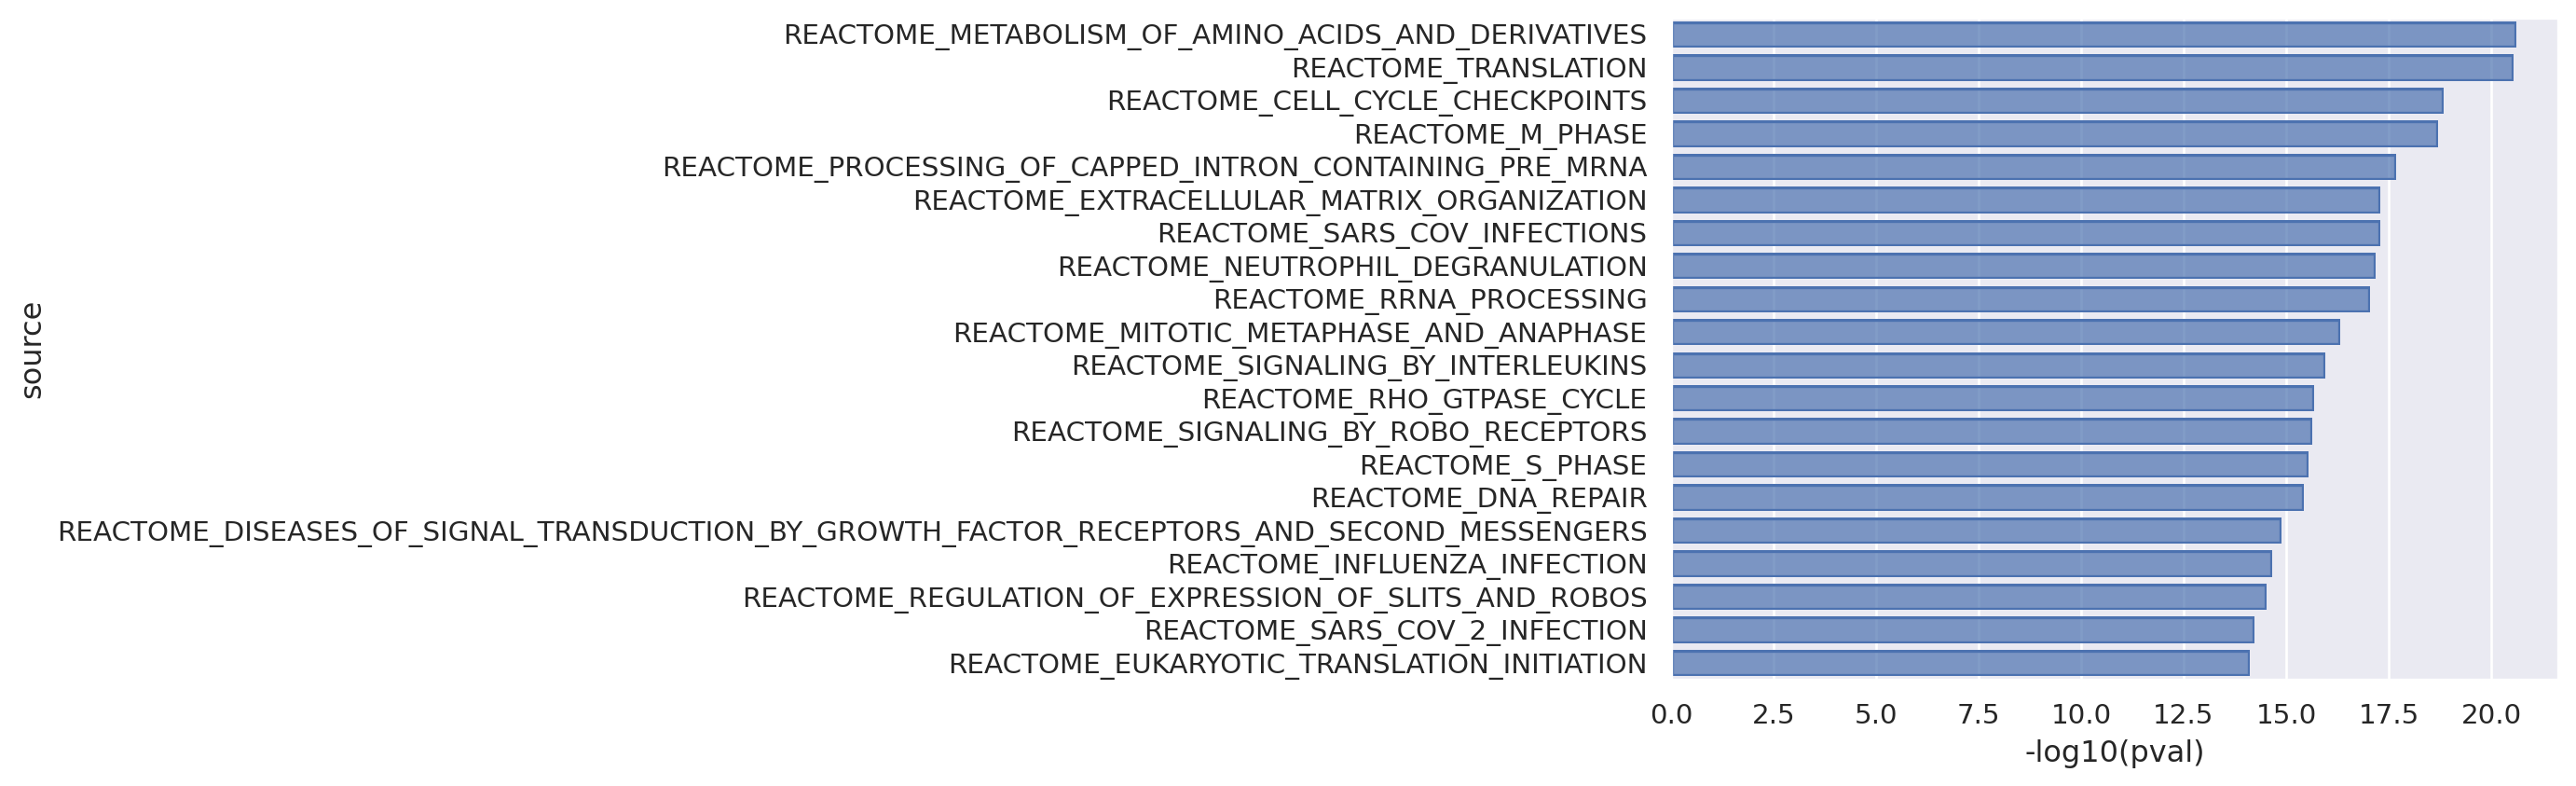

In [304]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [275]:
gsea_results.sort_values('pval')

,score,norm,pval
source,,,
REACTOME_CELL_CYCLE,0.469035,3.051780,0.002275
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,0.618527,3.049162,0.002295
REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES_AND_RHOBTB3,0.510930,3.017160,0.002552
REACTOME_CELL_CYCLE_MITOTIC,0.486789,2.858942,0.004251
REACTOME_DEVELOPMENTAL_BIOLOGY,0.415328,2.612161,0.008997
...,...,...,...
REACTOME_HOMOLOGY_DIRECTED_REPAIR,0.175387,0.528495,0.597156
REACTOME_DNA_DOUBLE_STRAND_BREAK_REPAIR,0.175387,0.528495,0.597156
REACTOME_INTERFERON_GAMMA_SIGNALING,-0.204265,-0.495582,0.620189


In [15]:
import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so

import session_info

from scipy import sparse
from sklearn.utils import check_random_state

In [16]:
print(datetime.now())
# adata = sc.read('/home/..../brainomics/Dati/1_AdataFilt.h5ad')
# adata = sc.read(config.PATHS.DATA/'2_AdataNorm.h5ad')
# adata = sc.read(config.PATHS.DATA/'1_AssembledAdata.h5ad')
adata = sc.read(config.PATHS.DATA/'1_AdataFilt.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

2023-09-14 07:12:17.222145
(36034, 23454)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 36034
Loaded Filtered AnnData object: number of genes 23454
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'sample_id', 'run_id', 'cell_label', 'n_genes_by_counts',
       'total_counts', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets'],
      dtype='object')


In [17]:
adata.obs['time'] = adata.obs.timepoint.apply(
    lambda x: 'd{}'.format(config.TIMEPOINT_MAP[x]))
adata.obs['replicate'] = adata.obs.timepoint.apply(
    lambda x: 'b{}'.format(config.BATCH_MAP[x]))
adata.obs['sample'] = \
    adata.obs.line.astype(str) + '_' + adata.obs.replicate + '_' + adata.obs.time

In [18]:
obs_to_keep = ["sample", "clusters", "replicate", "line", "time", "isHuman"]

In [19]:
# to pass the raw counts to edgeR .X is set 
# to the counts layer to ensure the pseudo-replicates
# are created for raw counts.
adata.layers['counts'] = adata.X.copy()
adata.X = adata.layers["counts"].copy()

In [20]:
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: "h{}".format(x.lower() in config.HUMANS))

In [21]:
idxs = np.prod([
    adata.obs.time.apply(lambda x: x in [ 'd14', 'd35' ]),
    adata.obs.clusters.apply(lambda x: x in ['C5', 'C4', 'C6', 'C7']),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,sample_id,run_id,cell_label,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,time,replicate,sample,isHuman
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,171212,C5,45.486102,-28.756658,409b2,NoInfo,C5,2438,7036,170,2.416146,1754,24.928937,0.056589,d14,b1,409b2_b1_d14,hTrue
AAACCTGCACGGCCAT-9.w2_409b2_171212,w2,409b2,171212,C7,36.626131,6.664266,409b2,NoInfo,C7,2572,7492,174,2.322477,1743,23.264816,0.056589,d14,b1,409b2_b1_d14,hTrue
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,171212,C5,36.483634,-26.967325,409b2,NoInfo,C5,2439,6413,226,3.524092,1417,22.095743,0.035814,d14,b1,409b2_b1_d14,hTrue
AAACCTGGTTTAAGCC-9.w2_409b2_171212,w2,409b2,171212,C7,35.570214,34.445170,409b2,NoInfo,C7,2750,8043,334,4.152679,1858,23.100833,0.066282,d14,b1,409b2_b1_d14,hTrue
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,171212,C5,36.968570,-28.070171,409b2,NoInfo,C5,2132,5279,144,2.727789,1199,22.712635,0.030606,d14,b1,409b2_b1_d14,hTrue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTAAGCTCCATTTCA.1.d35b2_joc_200908,d35b2,joc,200908,C5,40.172446,-81.497956,joc,NoInfo,C5,1582,2916,26,0.891632,265,9.087791,0.065413,d35,b4,joc_b4_d35,hFalse
TTCCGGTTCAACTGGT.1.d35b2_joc_200908,d35b2,joc,200908,C7,49.852562,59.854382,joc,NoInfo,C7,3068,6301,55,0.872877,550,8.728773,0.073703,d35,b4,joc_b4_d35,hFalse
TTGCTGCAGCCTATTG.1.d35b2_joc_200908,d35b2,joc,200908,C7,37.487645,47.619635,joc,NoInfo,C7,3500,9039,116,1.283328,954,10.554265,0.068966,d35,b4,joc_b4_d35,hFalse
TTGTGGAAGATCACCT.1.d35b2_joc_200908,d35b2,joc,200908,C7,55.044737,5.588699,joc,NoInfo,C7,2744,6811,103,1.512260,807,11.848480,0.230038,d35,b4,joc_b4_d35,hFalse


In [22]:
def subsampled_summation(
    adata,#: ad.AnnData,
    groupby, #: str | list[str],
    *,
    n_samples_per_group: int,
    n_cells: int,
    random_state,#: None | int | np.random.RandomState = None,
    layer,#: str = None,
): # -> ad.AnnData:
    """
    Sum sample of X per condition.

    Drops conditions which don't have enough samples.

    Parameters
    ----------
    adata
        AnnData to sum expression of
    groupby
        Keys in obs to groupby
    n_samples_per_group
        Number of samples to take per group
    n_cells
        Number of cells to take per sample
    random_state
        Random state to use when sampling cells
    layer
        Which layer of adata to use

    Returns
    -------
    AnnData with same var as original, obs with columns from groupby, and X.
    """

    # Checks
    if isinstance(groupby, str):
        groupby = [groupby]
    random_state = check_random_state(random_state)

    indices = []
    labels = []

    grouped = adata.obs.groupby(groupby)
    for k, inds in grouped.indices.items():
        # Check size of group
        if len(inds) < (n_cells * n_samples_per_group):
            continue

        # Sample from group
        condition_inds = random_state.choice(
            inds, n_cells * n_samples_per_group, replace=False
        )
        for i, sample_condition_inds in enumerate(np.split(condition_inds, 3)):
            if isinstance(k, tuple):
                labels.append((*k, i))
            else:  # only grouping by one variable
                labels.append((k, i))
            indices.append(sample_condition_inds)

    # obs of output AnnData
    new_obs = pd.DataFrame.from_records(
        labels,
        columns=[*groupby, "sample"],
        index=["-".join(map(str, l)) for l in labels],
    )
    n_out = len(labels)

    # Make indicator matrix
    indptr = np.arange(0, (n_out + 1) * n_cells, n_cells)
    indicator = sparse.csr_matrix(
        (
            np.ones(n_out * n_cells, dtype=bool),
            np.concatenate(indices),
            indptr,
        ),
        shape=(len(labels), adata.n_obs),
    )

    return ad.AnnData(
        X=indicator @ sc.get._get_obs_rep(adata, layer=layer),
        obs=new_obs,
        var=adata.var.copy(),
    )

In [27]:
pb_data = subsampled_summation(
    selected, ["isHuman", "time", "clusters"], n_cells=75, n_samples_per_group=3, layer="counts", random_state=42,
)
pb_data

AnnData object with n_obs × n_vars = 33 × 23454
    obs: 'isHuman', 'time', 'clusters', 'sample'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


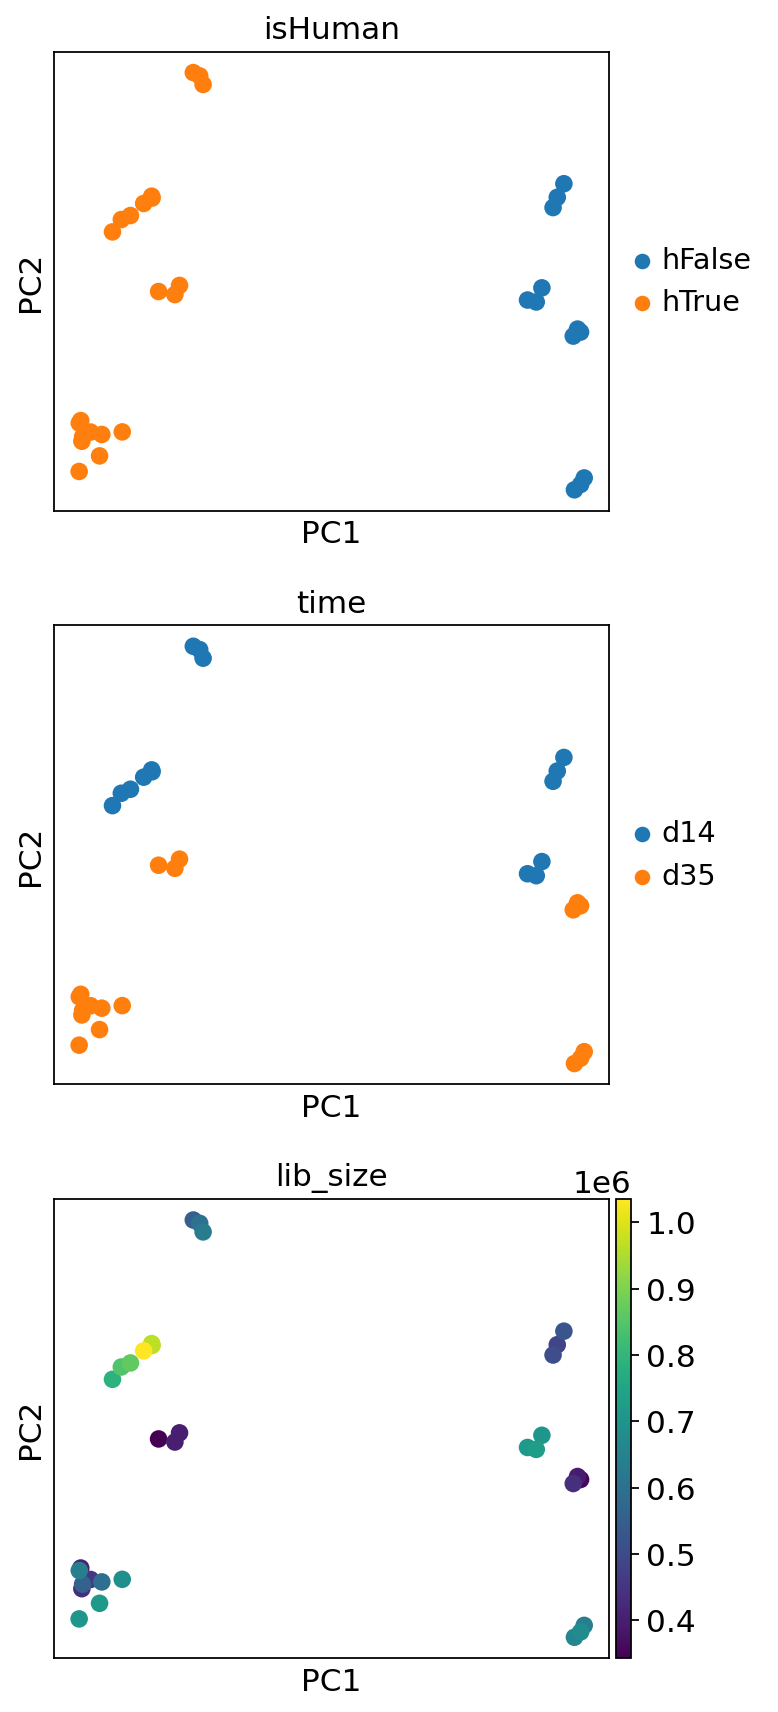

In [28]:
# Does PC1 captures a meaningful biological or technical fact?
pb_data.obs["lib_size"] = pb_data.X.sum(1)

# Let’s normalize this data and take a quick look at it. We won’t use a neighbor embedding here since the sample size is signifigantly reduced.
pb_data.layers["counts"] = pb_data.X.copy()

sc.pp.normalize_total(pb_data)
sc.pp.log1p(pb_data)
sc.pp.pca(pb_data)

sc.pl.pca(pb_data, color=["isHuman", "time", "lib_size"], ncols=1, size=250)

In [29]:
groups = pb_data.obs.time.astype("string") + "_" + pb_data.obs.isHuman

In [36]:
clusters = pb_data.obs.clusters.astype("string")

In [37]:
%%R -i groups -i clusters
group <-  as.factor(gsub(" |\\+","_", groups))
clusters <-  as.factor(gsub(" |\\+","_", clusters))
design <- model.matrix(~ 0 + group)
colnames(design)
dim(design)

[1] 33  4


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
4: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [38]:
%%R 
kang_pbmc_con <- limma::makeContrasts(
    
    # the effect if stimulus in CD16 Monocyte cells
    # groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes,
    "(groupd35_hTrue-groupd14_hTrue)-(groupd35_hFalse-groupd14_hFalse)",
    # the effect of stimulus in CD16 Monocytes compared to CD8 T Cells
    "(groupd14_hTrue-groupd14_hFalse)",
    # (groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes) - (groupstim_CD8_T_cells - groupctrl_CD8_T_cells), 
    levels = design
)
dim(kang_pbmc_con)

[1] 4 2


In [39]:
log_norm_X = pb_data.to_df().T

In [40]:
%%R -i log_norm_X -i reactome
# Move pathway info from python to R
pathways = split(reactome$genesymbol, reactome$geneset)
# Map gene names to indices
idx = limma::ids2indices(pathways, rownames(log_norm_X))

In [41]:
%%R
keep_gs <- lapply(idx, FUN=function(x) length(x) >= 15)
idx <- idx[unlist(keep_gs)]

In [42]:
%%R -o fry_results
fry_results <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,1])

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning message:
Zero sample variances detected, have been offset away from zero 


In [132]:
fry_results.head()

,NGenes,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
REACTOME_TGF_BETA_RECEPTOR_SIGNALING_IN_EMT_EPITHELIAL_TO_MESENCHYMAL_TRANSITION,16,Down,6.332908e-09,0.000005,9.144198e-16,3.373743e-14
REACTOME_LAMININ_INTERACTIONS,29,Down,9.663273e-09,0.000005,1.805622e-16,1.323263e-14
REACTOME_SIGNALING_BY_NTRK2_TRKB,25,Down,2.918856e-08,0.000010,5.125750e-16,2.504295e-14
REACTOME_SIGNALING_BY_MET,79,Down,4.742833e-08,0.000012,1.238253e-16,1.238517e-14
REACTOME_MET_PROMOTES_CELL_MOTILITY,41,Down,1.954090e-07,0.000040,1.566571e-16,1.323263e-14


In [43]:
fry_results.head()

,NGenes,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
REACTOME_INACTIVATION_OF_CSF3_G_CSF_SIGNALING,22,Up,0.000002,0.001946,1.801145e-06,1.038494e-05
REACTOME_CARBOXYTERMINAL_POST_TRANSLATIONAL_MODIFICATIONS_OF_TUBULIN,38,Down,0.000005,0.002435,2.359199e-09,6.593977e-08
REACTOME_SARS_COV_2_HOST_INTERACTIONS,178,Up,0.000007,0.002435,1.837710e-06,1.041708e-05
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,56,Up,0.000011,0.002940,4.037281e-05,1.274539e-04
REACTOME_SIGNALING_BY_CSF3_G_CSF,27,Up,0.000023,0.004710,1.757045e-07,1.798820e-06


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


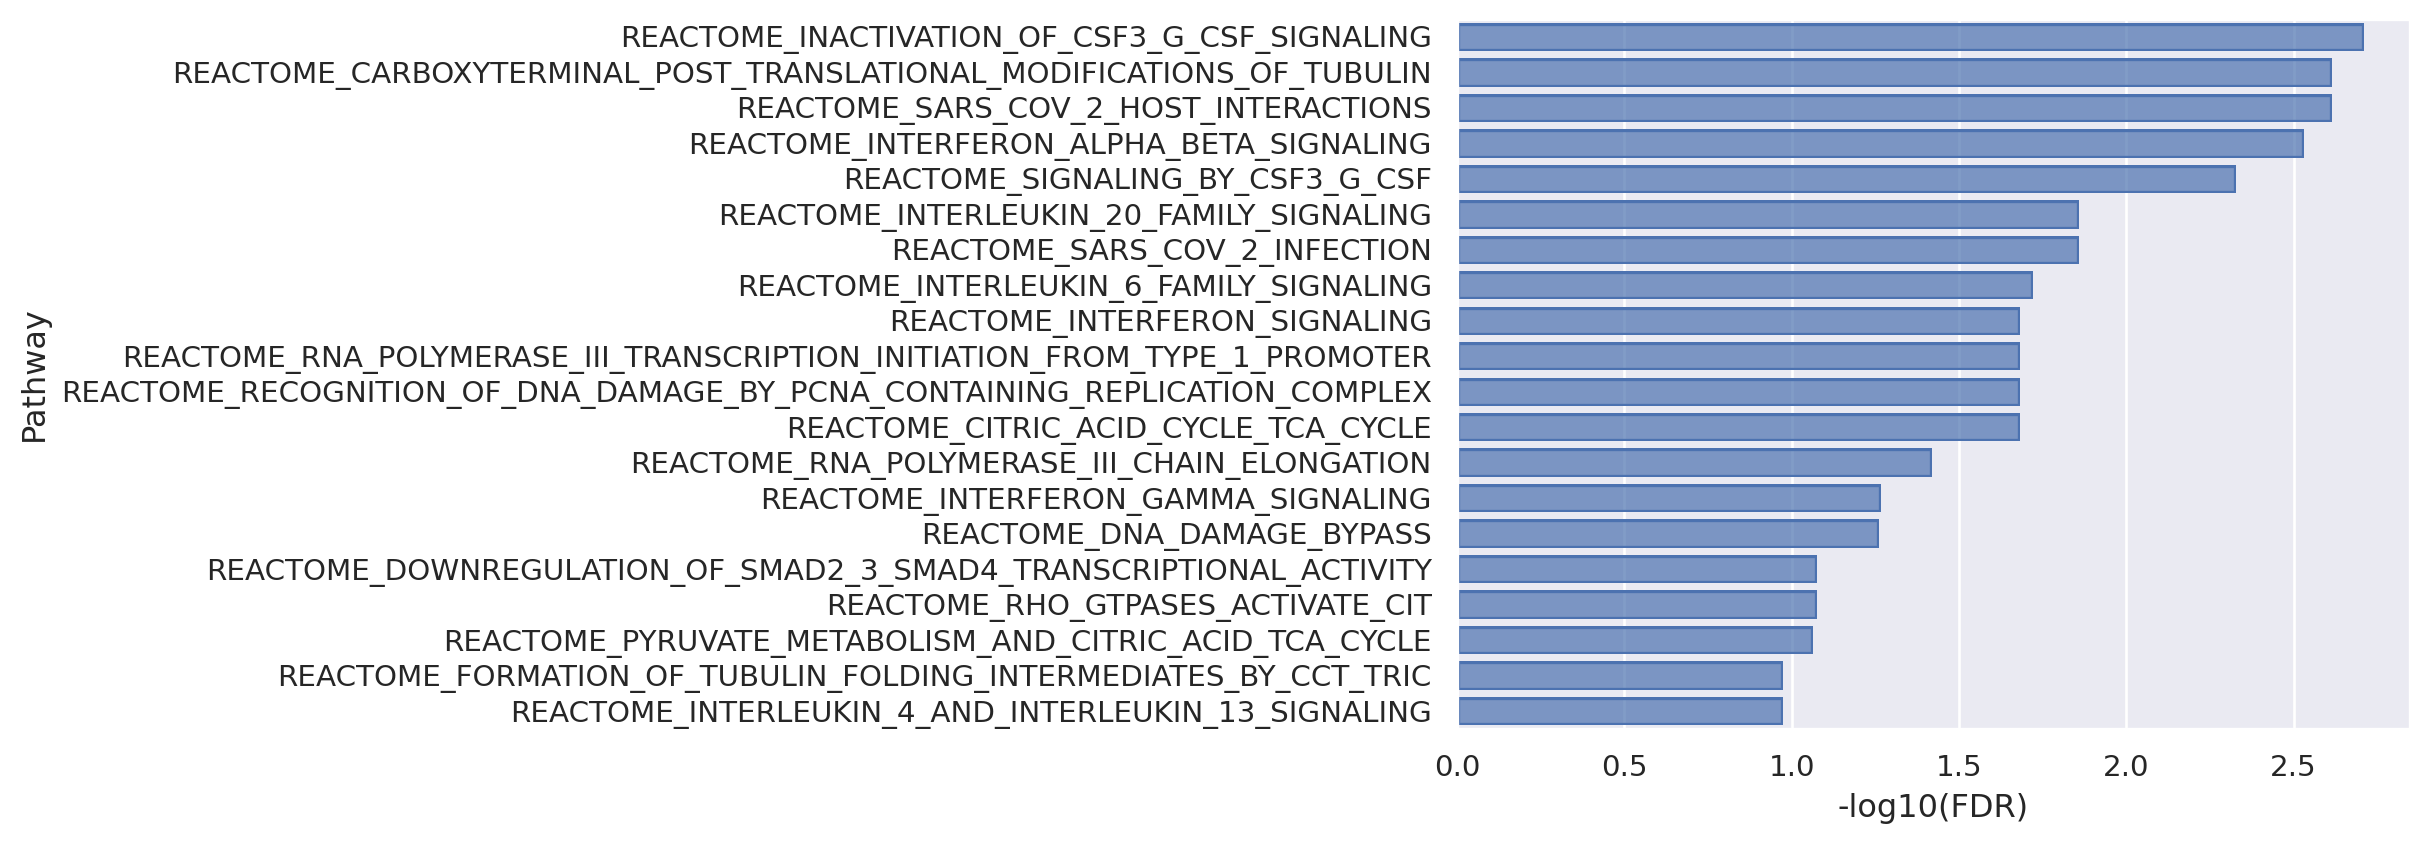

In [44]:
(
    so.Plot(
        data=(
            fry_results.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

In [45]:
%%R -o fry_results_negative_ctrl
fry_results_negative_ctrl <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,2])

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning message:
Zero sample variances detected, have been offset away from zero 


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


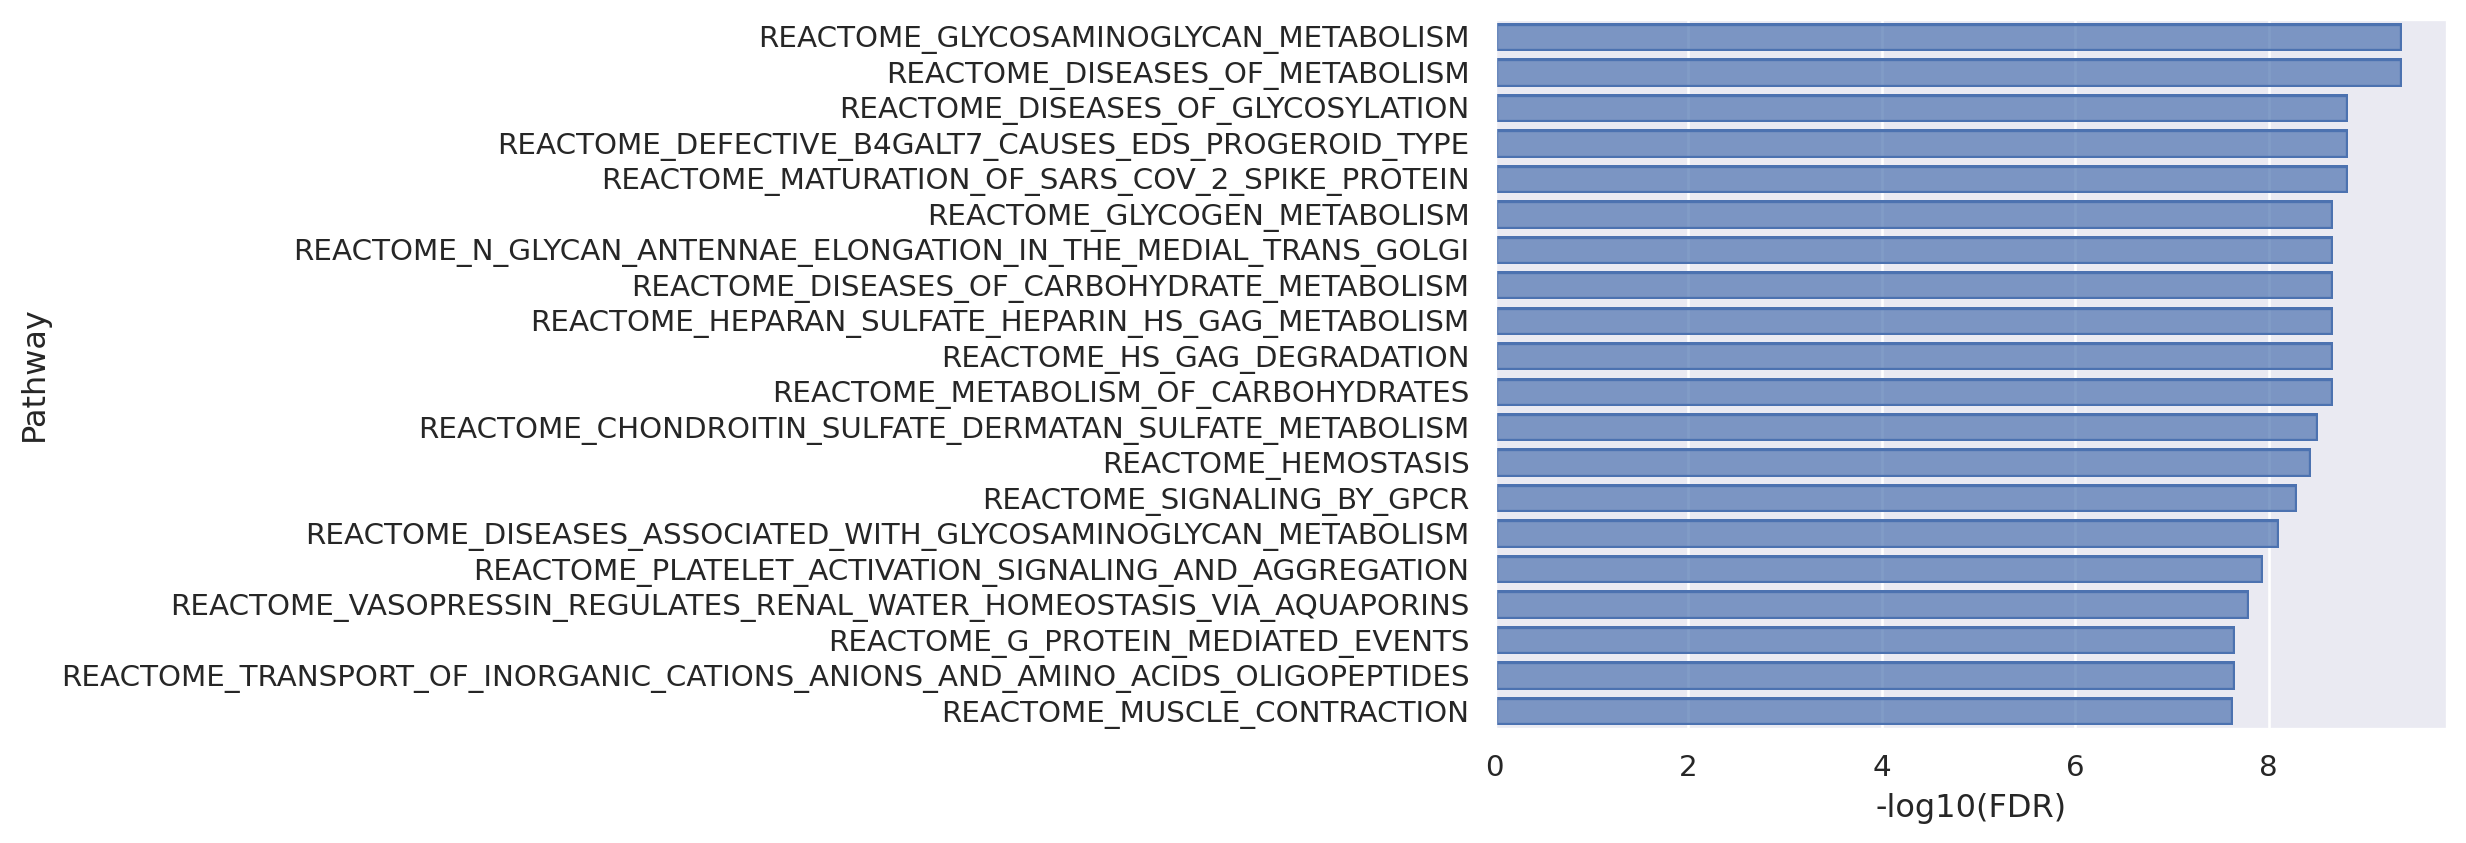

In [46]:
(
    so.Plot(
        data=(
            fry_results_negative_ctrl.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


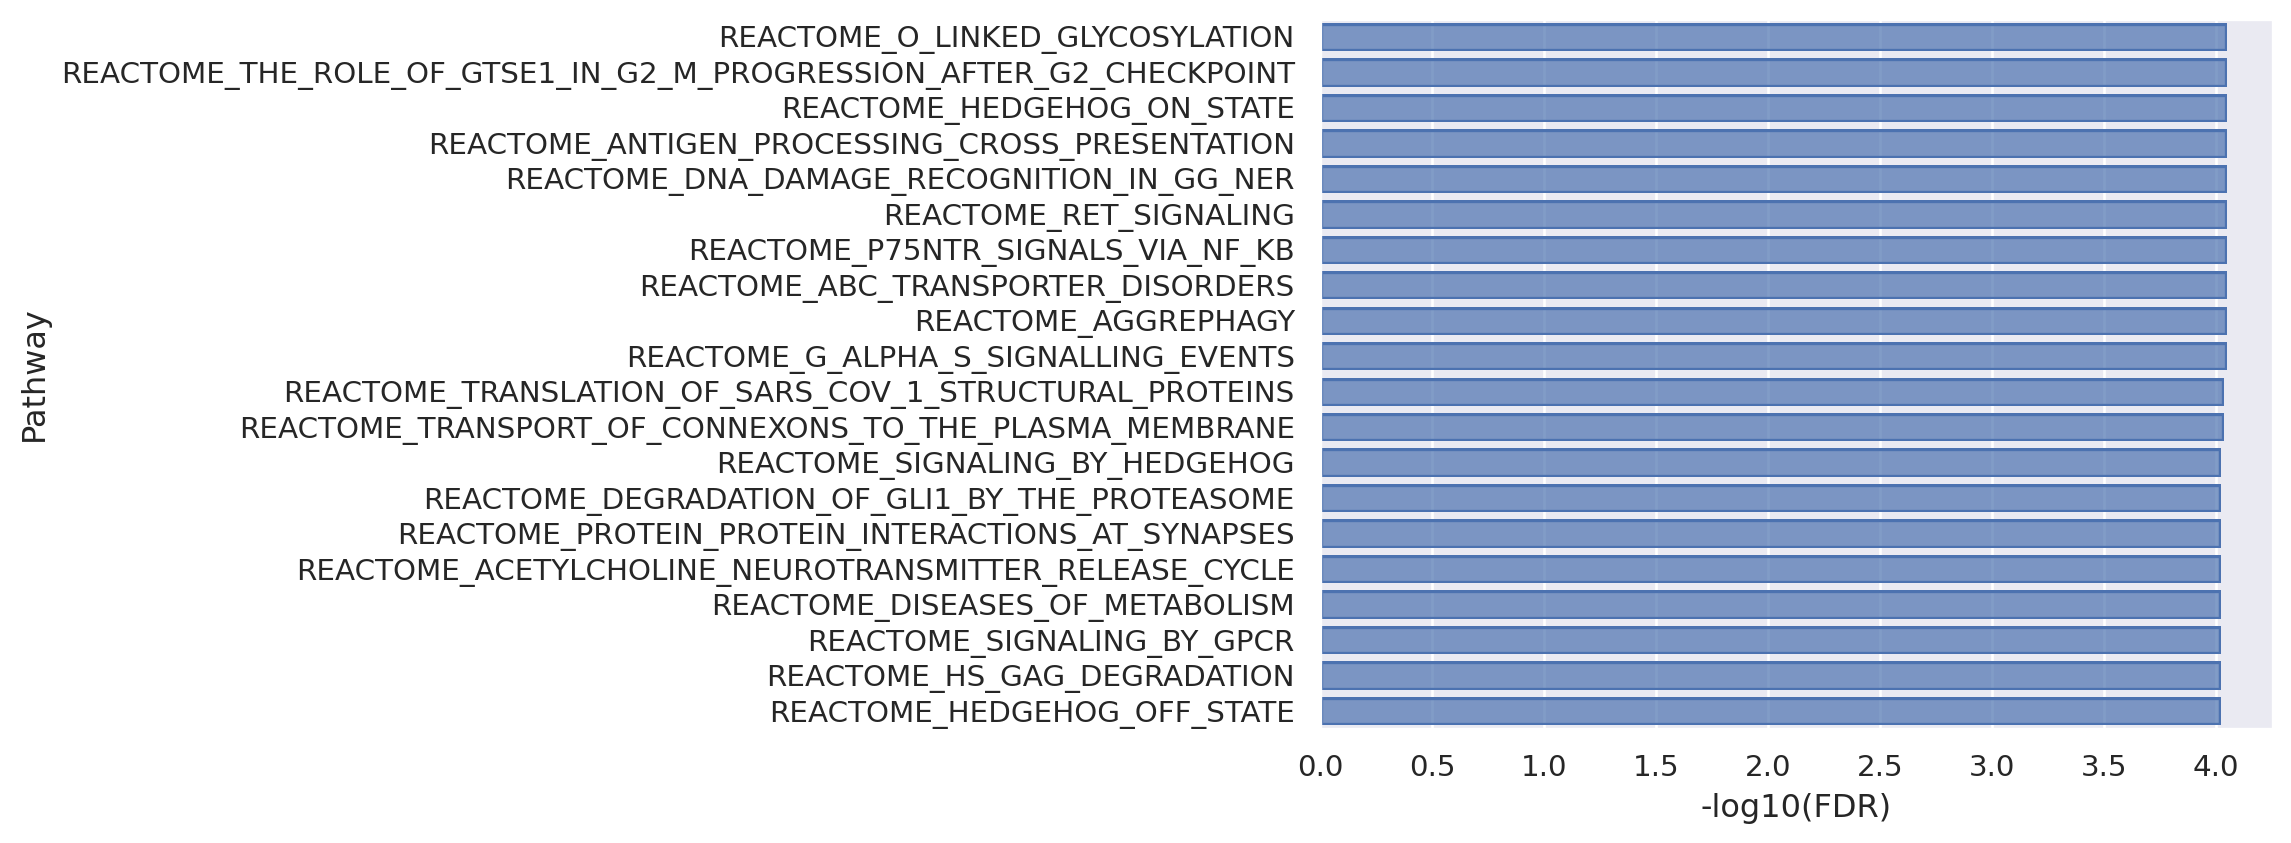

In [125]:
(
    so.Plot(
        data=(
            fry_results_negative_ctrl.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)